# Sentiment Analysis

_Artificial Intelligence Nanodegree Program | Natural Language Processing_

---

With the rise of online social media platforms like Twitter, Facebook and Reddit, and the proliferation of customer reviews on sites like Amazon and Yelp, we now have access, more than ever before, to massive text-based data sets! They can be analyzed in order to determine how large portions of the population feel about certain products, events, etc. This sort of analysis is called _sentiment analysis_. In this notebook you will build an end-to-end sentiment classification system from scratch.

## Instructions

Some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this notebook. You will not need to modify the included code beyond what is requested. Sections that begin with '**TODO**' in the header indicate that you need to complete or implement some portion within them. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `# TODO: ...` comment. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions for you to answer which relate to the task and your implementation. Each section where you will answer a question is preceded by a '**Question:**' header. Carefully read each question and provide your answer below the '**Answer:**' header by editing the Markdown cell.

> **Note**: Code and Markdown cells can be executed using the **Shift+Enter** keyboard shortcut. In addition, a cell can be edited by typically clicking it (double-click for Markdown cells) or by pressing **Enter** while it is highlighted.

## Step 1: Exploring the data!

The dataset we are going to use is very popular among researchers in Natural Language Processing, usually referred to as the [IMDb dataset](http://ai.stanford.edu/~amaas/data/sentiment/). It consists of movie reviews from the website [imdb.com](http://www.imdb.com/), each labeled as either '**pos**itive', if the reviewer enjoyed the film, or '**neg**ative' otherwise.

> Maas, Andrew L., et al. [Learning Word Vectors for Sentiment Analysis](http://ai.stanford.edu/~amaas/data/sentiment/). In _Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies_. Association for Computational Linguistics, 2011.

We have provided the dataset for you. You can load it in by executing the Python cell below.

In [1]:
import os
import glob

def read_imdb_data(data_dir='data/imdb-reviews'):
    """Read IMDb movie reviews from given directory.
    
    Directory structure expected:
    - data/
        - train/
            - pos/
            - neg/
        - test/
            - pos/
            - neg/
    
    """

    # Data, labels to be returned in nested dicts matching the dir. structure
    data = {}
    labels = {}

    # Assume 2 sub-directories: train, test
    for data_type in ['train', 'test']:
        data[data_type] = {}
        labels[data_type] = {}

        # Assume 2 sub-directories for sentiment (label): pos, neg
        for sentiment in ['pos', 'neg']:
            data[data_type][sentiment] = []
            labels[data_type][sentiment] = []
            
            # Fetch list of files for this sentiment
            path = os.path.join(data_dir, data_type, sentiment, '*.txt')
            files = glob.glob(path)
            
            # Read reviews data and assign labels
            for f in files:
                with open(f) as review:
                    data[data_type][sentiment].append(review.read())
                    labels[data_type][sentiment].append(sentiment)
            
            assert len(data[data_type][sentiment]) == len(labels[data_type][sentiment]), \
                    "{}/{} data size does not match labels size".format(data_type, sentiment)
    
    # Return data, labels as nested dicts
    return data, labels


data, labels = read_imdb_data()
print("IMDb reviews: train = {} pos / {} neg, test = {} pos / {} neg".format(
        len(data['train']['pos']), len(data['train']['neg']),
        len(data['test']['pos']), len(data['test']['neg'])))

IMDb reviews: train = 12500 pos / 12500 neg, test = 12500 pos / 12500 neg


Now that the data is loaded in, let's take a quick look at one of the positive reviews:

In [2]:
print(data['train']['pos'][1])

While the original 1932 version, with Preston Foster, was good, there's no remake more worthy than this 1959 one, or more impossible to find anywhere, just as I strongly suspect Mickey Rooney to have had something to do with that. Never could a mere performance have ever been so masterfully brilliant, or a script more thought-provoking, as well as an improvement upon the original. Many years after the last of my several viewings of this film, in 1970, I read an article in which Mickey Rooney was recounting a visit he'd made to death row, and which had apparently very drastically eliminated whatever sense of personal identification he'd felt with people in similar circumstances. The article was about as short as the main character here, and didn't cover much, other than the extent to which his extreme disillusionment with the quality of the inmates themselves had been emphasized, even in language I would not care to explicitly quote here. . . . . One of my main problems with capital pun

And one with a negative sentiment:

In [3]:
print(data['train']['neg'][1])

I was honestly surprised by Alone in the Dark. It was so bad, I could hardly believe what I was seeing. There are no characters, just a few stereotypes wandering around and getting killed. The extent of the character development was giving each character a name and an occupation, and that's about it. There was no real plot, and none of the characters seemed to have any motivation. In fact, many action scenes just began on their own, coming from nowhere with a pounding techno track. While I was watching this movie I kept asking "Where is this happening? What's going on?" The acting was high school drama quality, with stiff wooden delivery, as though the actors were reading from cue cards without comprehending their lines. Their trouble delivering lines was made even more obvious by horrible sound design. ADR sounded like it was recorded in an open room. The actors were constantly taking obvious care to hit their marks, looking almost robotic in their movements. So, these listless automa

We can also make a wordcloud visualization of the reviews.

In [4]:
# Installing wordcloud
!pip install wordcloud

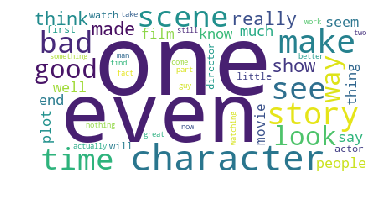

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS

sentiment = 'neg'

# Combine all reviews for the desired sentiment
combined_text = " ".join([review for review in data['train'][sentiment]])

# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50,
        # update stopwords to include common words like film and movie
        stopwords = STOPWORDS.update(['br','film','movie']))

# Generate and plot wordcloud
plt.imshow(wc.generate(combined_text))
plt.axis('off')
plt.show()

Try changing the sentiment to `'neg'` and see if you can spot any obvious differences between the wordclouds.

### TODO: Form training and test sets

Now that you've seen what the raw data looks like, combine the positive and negative documents to get one unified training set and one unified test set.

In [6]:
from sklearn.utils import shuffle

def prepare_imdb_data(data):
    """Prepare training and test sets from IMDb movie reviews."""
    data_train= data['train']['pos'] + data['train']['neg']
    positive_train_labels = [1 for review in data['train']['pos']]
    negative_train_labels = [0 for review in data['train']['neg']]
    labels_train = positive_train_labels + negative_train_labels
    
    data_test= data['test']['pos'] + data['test']['neg']
    positive_test_labels = [1 for review in data['test']['pos']]
    negative_test_labels = [0 for review in data['test']['neg']]
    labels_test = positive_test_labels + negative_test_labels
    
    data_train, data_test, labels_train, labels_test = shuffle(data_train, data_test, labels_train, labels_test)
    
    # Return a unified training data, test data, training labels, test labets
    return data_train, data_test, labels_train, labels_test


data_train, data_test, labels_train, labels_test = prepare_imdb_data(data)
print("IMDb reviews (combined): train = {}, test = {}".format(len(data_train), len(data_test)))

IMDb reviews (combined): train = 25000, test = 25000


## Step 2. Preprocessing

As you might have noticed in the sample reviews, our raw data includes HTML. Therefore there are HTML tags that need to be removed. We also need to remove non-letter characters, normalize uppercase letters by converting them to lowercase, tokenize, remove stop words, and stem the remaining words in each document.

### TODO: Convert each review to words

As your next task, you should complete the function `review_to_words()` that performs all these steps. For your convenience, in the Python cell below we provide you with all the libraries that you may need in order to accomplish these preprocessing steps. Make sure you can import all of them! (If not, pip install from a terminal and run/import again.)

In [7]:
# BeautifulSoup to easily remove HTML tags
from bs4 import BeautifulSoup 

# RegEx for removing non-letter characters
import re

# NLTK library for the remaining steps
import nltk
nltk.download("stopwords")   # download list of stopwords (only once; need not run it again)
from nltk.corpus import stopwords # import stopwords
stop_words = set(stopwords.words('english'))

from nltk.stem.porter import *
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
def review_to_words(review):
    """Convert a raw review string into a sequence of words."""
    
    # TODO: Remove HTML tags and non-letters,
    #       convert to lowercase, tokenize,
    #       remove stopwords and stem
    review = BeautifulSoup(review, 'html.parser').get_text()
    review = re.sub('\W+', ' ', review)
    review = review.lower()
    words = review.split()
    words = [stemmer.stem(word) for word in words if not word in stop_words]

    # Return final list of words
    return words


review_to_words("""This is just a <em>test</em>.<br/><br />
But if it wasn't a test, it would make for a <b>Great</b> movie review!""")

['test', 'test', 'would', 'make', 'great', 'movi', 'review']

With the function `review_to_words()` fully implemeneted, we can apply it to all reviews in both training and test datasets. This may take a while, so let's build in a mechanism to write to a cache file and retrieve from it later.

In [9]:
import pickle

cache_dir = os.path.join("cache", "sentiment_analysis")  # where to store cache files
os.makedirs(cache_dir, exist_ok=True)  # ensure cache directory exists

def preprocess_data(data_train, data_test, labels_train, labels_test,
                    cache_dir=cache_dir, cache_file="preprocessed_data.pkl"):
    """Convert each review to words; read from cache if available."""

    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = pickle.load(f)
            print("Read preprocessed data from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # Preprocess training and test data to obtain words for each review
        words_train = list(map(review_to_words, data_train))
        words_test = list(map(review_to_words, data_test))
        
        # Write to cache file for future runs
        if cache_file is not None:
            cache_data = dict(words_train=words_train, words_test=words_test,
                              labels_train=labels_train, labels_test=labels_test)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                pickle.dump(cache_data, f)
            print("Wrote preprocessed data to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        words_train, words_test, labels_train, labels_test = (cache_data['words_train'],
                cache_data['words_test'], cache_data['labels_train'], cache_data['labels_test'])
    
    return words_train, words_test, labels_train, labels_test


# Preprocess data
words_train, words_test, labels_train, labels_test = preprocess_data(
        data_train, data_test, labels_train, labels_test)

# Take a look at a sample
print("\n--- Raw review ---")
print(data_train[1])
print("\n--- Preprocessed words ---")
print(words_train[1])
print("\n--- Label ---")
print(labels_train[1])

Read preprocessed data from cache file: preprocessed_data.pkl

--- Raw review ---
I don't have much to add to what has been said before, but it's very much a film of it's time, and the first (and likely only) time that the studio hung the film totally on the Dead End Kids.<br /><br />The Warner's gave the boys plenty of help, from director Ray Enright and an 'A' budget, to an almost magical cast of supporting actors. At every turn, we get one of those gem performances from real pros. They are too many to list, but it seems like just about everybody on the Warner's lot (Sans the very biggest stars) walk through this picture. (See if you can spot John Ridgely)<br /><br />The only over the top performance is from the always reliable Eduardo Cianelli as a mob boss with a messianistic complex. He plays this character almost exactly like that of the Thuggie leader in "Gunga Din". He's something to watch! And Marjorie Main is excellent and gets her best role since "Dead End".<br /><br />My bi

## Step 3: Extracting Bag-of-Words features

Now that each document has been preprocessed, we can transform each into a Bag-of-Words feature representation. Note that we need to create this transformation based on the training data alone, as we are not allowed to peek at the testing data at all!

The dictionary or _vocabulary_ $V$ (set of words shared by documents in the training set) used here will be the one on which we train our supervised learning algorithm. Any future test data must be transformed in the same way for us to be able to apply the learned model for prediction. Hence, it is important to store the transformation / vocabulary as well.

> **Note**: The set of words in the training set may not be exactly the same as the test set. What do you do if you encounter a word during testing that you haven't seen before? Unfortunately, we'll have to ignore it, or replace it with a special `<UNK>` token.

### TODO: Compute Bag-of-Words features

Implement the `extract_BoW_features()` function, apply it to both training and test datasets, and store the results in `features_train` and `features_test` NumPy arrays, respectively. Choose a reasonable vocabulary size, say $|V| = 5000$, and keep only the top $|V|$ occuring words and discard the rest. This number will also serve as the number of columns in the BoW matrices.

> **Hint**: You may find it useful to take advantage of `CountVectorizer` from scikit-learn. Also make sure to pickle your Bag-of-Words transformation so that you can use it in future.

In [10]:
words_train

[['movi',
  'make',
  'cri',
  'end',
  'watch',
  'least',
  '3',
  '4',
  'movi',
  'week',
  'seen',
  'load',
  'great',
  'movi',
  'even',
  'crap',
  'one',
  'end',
  'scene',
  'cathars',
  'core',
  'came',
  'cri',
  'seriou',
  'problem',
  'stori',
  'archetyp',
  'noth',
  'new',
  'origin',
  'real',
  'sort',
  'thing',
  'realli',
  'happen',
  'peopl',
  'realli',
  'exist',
  'glam',
  'sort',
  'music',
  'realli',
  'admir',
  'went',
  'earli',
  '70',
  'point',
  'direct',
  'toward',
  'velvet',
  'goldmin',
  'docudrama',
  'never',
  'realli',
  'work',
  'good',
  'movi',
  'realli',
  'meke',
  'us',
  'believ',
  'tri',
  'make',
  'path',
  'full',
  'gloriou',
  'concert',
  'present',
  'musician',
  'superhero',
  'groupi',
  'girl',
  'stupid',
  'emot',
  'numb',
  'glorifi',
  'drug',
  'alcohol',
  'promot',
  'rehabilit',
  'redempt',
  'come',
  'even',
  '20',
  'year',
  'late',
  'great',
  'movi',
  'sinc',
  'leav',
  'la',
  'vega',
  'neve

In [11]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.externals import joblib
# joblib is an enhanced version of pickle that is more efficient for storing NumPy arrays

def extract_BoW_features(words_train, words_test, vocabulary_size=5000,
                         cache_dir=cache_dir, cache_file="bow_features.pkl"):
    """Extract Bag-of-Words for a given set of documents, already preprocessed into words."""
    
    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = joblib.load(f)
            print("Read features from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # TODO: Fit a vectorizer to training documents and use it to transform them
        # NOTE: Training documents have already been preprocessed and tokenized into words;
        #       pass in dummy functions to skip those steps, e.g. preprocessor=lambda x: x
        vectorizer = CountVectorizer(preprocessor=lambda x: x, tokenizer=lambda x: x, max_features=vocabulary_size)
        features_train = vectorizer.fit_transform(words_train).toarray()

        # TODO: Apply the same vectorizer to transform the test documents (ignore unknown words)
        features_test = vectorizer.fit_transform(words_test).toarray()
        
        # NOTE: Remember to convert the features using .toarray() for a compact representation
        
        # Write to cache file for future runs (store vocabulary as well)
        if cache_file is not None:
            vocabulary = vectorizer.vocabulary_
            cache_data = dict(features_train=features_train, features_test=features_test,
                             vocabulary=vocabulary)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                joblib.dump(cache_data, f)
            print("Wrote features to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        features_train, features_test, vocabulary = (cache_data['features_train'],
                cache_data['features_test'], cache_data['vocabulary'])
    
    # Return both the extracted features as well as the vocabulary
    return features_train, features_test, vocabulary


# Extract Bag of Words features for both training and test datasets
features_train, features_test, vocabulary = extract_BoW_features(words_train, words_test)

# Inspect the vocabulary that was computed
print("Vocabulary: {} words".format(len(vocabulary)))

import random
print("Sample words: {}".format(random.sample(list(vocabulary.keys()), 8)))

# Sample
print("\n--- Preprocessed words ---")
print(words_train[5])
print("\n--- Bag-of-Words features ---")
print(features_train[5])
print("\n--- Label ---")
print(labels_train[5])

Read features from cache file: bow_features.pkl
Vocabulary: 5000 words
Sample words: ['encourag', 'match', 'psych', 'bam', 'journey', 'transcend', 'freedom', 'cruel']

--- Preprocessed words ---
['kid', '50', '60', 'anyth', 'connect', 'disney', 'definit', 'great', 'happen', 'abl', 'get', 'actor', 'actress', 'want', 'best', 'time', 'somehow', 'disney', 'manag', 'screw', 'thing', 'spite', 'abund', 'resourc', 'disney', 'afford', 'best', 'writer', 'best', 'produc', 'director', 'still', 'screw', 'thing', 'movi', 'crap', 'sad', 'thing', 'suspect', 'disney', 'arrog', 'even', 'know', 'movi', 'good', 'bad', 'due', 'talent', 'actor', 'even', 'give', '3', '10']

--- Bag-of-Words features ---
[0 0 0 ... 0 0 0]

--- Label ---
neg


Let's try to visualize the Bag-of-Words feature vector for one of our training documents.

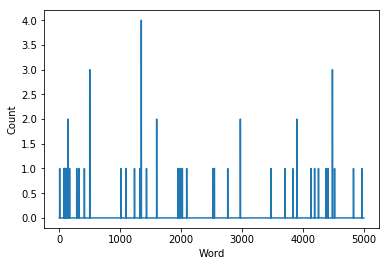

In [12]:
# Plot the BoW feature vector for a training document
plt.plot(features_train[5,:])
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

In [13]:
zeroEntries = 0
totalWords = 0
for bow_doc in features_train:
    for feature_value in bow_doc:
        totalWords += 1
        if feature_value == 0:
            zeroEntries += 1

bowSparcity = zeroEntries/totalWords
print("BoW sparcity: {}".format(bowSparcity))

BoW sparcity: 0.983087872


#### Question: Reflecting on Bag-of-Words feature representation

What is the average sparsity level of BoW vectors in our training set? In other words, on average what percentage of entries in a BoW feature vector are zero?

#### Answer:
About 98%. 
...

### Zipf's law

[Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law), named after the famous American linguist George Zipf, is an empirical law stating that given a large collection of documents, the frequency of any word is inversely proportional to its rank in the frequency table. So the most frequent word will occur about twice as often as the second most frequent word, three times as often as the third most frequent word, and so on. In the figure below we plot number of appearances of each word in our training set against its rank.

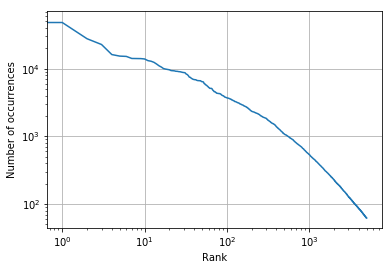

In [14]:
# Find number of occurrences for each word in the training set
word_freq = features_train.sum(axis=0)

# Sort it in descending order
sorted_word_freq = np.sort(word_freq)[::-1]

# Plot 
plt.plot(sorted_word_freq)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.xlabel('Rank')
plt.ylabel('Number of occurrences')
plt.grid()
plt.show()

#### Question: Zipf's law

What is the total number of occurrences of the most frequent word? What is the the total number of occurrences of the second most frequent word? Do your numbers follow  Zipf's law? If not, why?

#### Answer:

First: 51695 occurrences. Second: 48190 occurrences. It didn't follow Zipf's law because there was a preprocessing step, where stop (common) words were removed.

### TODO: Normalize feature vectors

Bag-of-Words features are intuitive to understand as they are simply word counts. But counts can vary a lot, and potentially throw off learning algorithms later in the pipeline. So, before we proceed further, let's normalize the BoW feature vectors to have unit length.

This makes sure that each document's representation retains the unique mixture of feature components, but prevents documents with large word counts from dominating those with fewer words.

In [15]:
import sklearn.preprocessing as pr

# TODO: Normalize BoW features in training and test set
features_train = pr.normalize(features_train)
features_test = pr.normalize(features_test)

## Step 4: Classification using BoW features

Now that the data has all been properly transformed, we can feed it into a classifier. To get a baseline model, we train a Naive Bayes classifier from scikit-learn (specifically, [`GaussianNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)), and evaluate its accuracy on the test set.

In [17]:
from sklearn.naive_bayes import GaussianNB

# TODO: Train a Guassian Naive Bayes classifier
clf1 = GaussianNB()
clf1.fit(features_train, labels_train)

# Calculate the mean accuracy score on training and test sets
print("[{}] Accuracy: train = {}, test = {}".format(
        clf1.__class__.__name__,
        clf1.score(features_train, labels_train),
        clf1.score(features_test, labels_test)))

[GaussianNB] Accuracy: train = 0.8198, test = 0.49596


Tree-based algorithms often work quite well on Bag-of-Words as their highly discontinuous and sparse nature is nicely matched by the structure of trees. As your next task, you will try to improve on the Naive Bayes classifier's performance by using scikit-learn's Gradient-Boosted Decision Tree classifer.

### TODO: Gradient-Boosted Decision Tree classifier

Use [`GradientBoostingClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) from scikit-learn to classify the BoW data. This model has a number of parameters. We use default parameters for some of them and pre-set the rest for you, except one: `n_estimators`. Find a proper value for this hyperparameter, use it to classify the data, and report how much improvement you get over Naive Bayes in terms of accuracy.

> **Tip**: Use a model selection technique such as cross-validation, grid-search, or an information criterion method, to find an optimal value for the hyperparameter.

In [19]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

n_estimators = 32

def classify_gboost(X_train, X_test, y_train, y_test):        
    # Initialize classifier
    clf = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=1.0, max_depth=1, random_state=0)

    # TODO: Classify the data using GradientBoostingClassifier
    clf.fit(X_train, y_train)
    # TODO(optional): Perform hyperparameter tuning / model selection
#     parameters = {'n_estimators': [8, 16, 32, 64, 128]}

#     clf = GridSearchCV(GradientBoostingClassifier(), parameters, cv=10, n_jobs=-1)

#     clf.fit(X_train, y_train)
    
    # TODO: Print final training & test accuracy
    print("[{}] Accuracy: train = {}, test = {}".format(
        clf.__class__.__name__,
        clf.score(X_train, y_train),
        clf.score(X_test, y_test)))
#     print("Best params: {}".format(clf.best_params_))
    # Return best classifier model
    return clf


clf2 = classify_gboost(features_train, features_test, labels_train, labels_test)

[GradientBoostingClassifier] Accuracy: train = 0.79472, test = 0.51764


AttributeError: 'GradientBoostingClassifier' object has no attribute 'best_params_'

### TODO: Adverserial testing

Write a short movie review to trick your machine learning model! That is, a movie review with a clear positive or negative sentiment that your model will classify incorrectly.

> **Hint**: You might want to take advantage of the biggest weakness of the Bag-of-Words scheme!

In [ ]:
# TODO: Write a sample review and set its true sentiment
my_review = "..."
true_sentiment = ''  # sentiment must be 'pos' or 'neg'

# TODO: Apply the same preprocessing and vectorizing steps as you did for your training data

# TODO: Then call your classifier to label it


## Extensions

There are several ways in which you can build upon this notebook. Each comes with its set of challenges, but can be a rewarding experience.

- The first thing is to try and improve the accuracy of your model by experimenting with different architectures, layers and parameters. How good can you get without taking prohibitively long to train? How do you prevent overfitting?

- Then, you may want to deploy your model as a mobile app or web service. What do you need to do in order to package your model for such deployment? How would you accept a new review, convert it into a form suitable for your model, and perform the actual prediction? (Note that the same environment you used during training may not be available.)

- One simplification we made in this notebook is to limit the task to binary classification. The dataset actually includes a more fine-grained review rating that is indicated in each review's filename (which is of the form `<[id]_[rating].txt>` where `[id]` is a unique identifier and `[rating]` is on a scale of 1-10; note that neutral reviews > 4 or < 7 have been excluded). How would you modify the notebook to perform regression on the review ratings? In what situations is regression more useful than classification, and vice-versa?

Whatever direction you take, make sure to share your results and learnings with your peers, through blogs, discussions and participating in online competitions. This is also a great way to become more visible to potential employers!